In [1]:
!date

Sun Aug 10 08:00:18 PM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

In [3]:
!which python

~/anaconda3/envs/DeNN/bin/python


In [4]:
import nibabel as nib
import os
import random
import matplotlib.pyplot as plt
import sys
import numpy
np = numpy
print(numpy.__version__)
import h5py

# os.environ["CUDA_VISIBLE_DEVICES"]="1"
# import keras
# from keras.layers import Conv1D,Input,LSTM,TimeDistributed,concatenate,Dense
# from keras.models import Model
# #from keras.optimizers.legacy import Adam
# from keras.optimizers import Adam
# import tensorflow as tf
# import keras.backend as T
# from keras.constraints import non_neg,Constraint
# dense_size = 128


import tensorflow as tf
#import keras
from tensorflow.keras.layers import Conv1D,Input,LSTM,TimeDistributed,concatenate,Dense
from tensorflow.keras.models import Model
#from keras.optimizers.legacy import Adam
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam

import tensorflow.keras.backend as T
from tensorflow.keras.constraints import non_neg,Constraint
dense_size = 128



import scipy
import scipy.io as si
from scipy.stats.mstats import zscore
from scipy.io import savemat
import sklearn
from sklearn.model_selection import train_test_split

1.24.3


2025-08-10 20:00:19.473473: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-10 20:00:19.528098: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-10 20:00:19.575645: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-10 20:00:19.576289: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-10 20:00:20.678990: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [5]:
#tf.compat.v1.disable_v2_behavior()   # back to graph mode, brings back tf.get_default_graph

In [6]:
print(nib.__version__)
#print(keras.__version__)
#print(scipy.__version__)
#print(sklearn.__version__)
print(tf.__version__)

5.2.1
2.13.1


In [7]:
print(tf.__version__)

2.13.1


In [8]:
tf.__file__

'/home/aglinska/anaconda3/envs/DeNN/lib/python3.8/site-packages/tensorflow/__init__.py'

In [9]:
import keras
keras.__version__

'2.13.1'

In [10]:
import sys
print(sys.executable)

/home/aglinska/anaconda3/envs/DeNN/bin/python


In [11]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)

# 2) force TF deterministic behavior (disable oneDNN optimizations if needed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# 3) standard RNG seeds
import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

# 4) TensorFlow 2.x seed
import tensorflow as tf
tf.random.set_seed(SEED)

# 5) for TF1 graph mode (since you call disable_v2_behavior)
tf.compat.v1.set_random_seed(SEED)

In [12]:
def correlate_columns(arr1, arr2):
    """
    Computes the Pearson correlation between corresponding columns of two matrices.
    
    Parameters:
    arr1 (np.ndarray): First matrix of shape (370, 1000)
    arr2 (np.ndarray): Second matrix of shape (370, 1000)
    
    Returns:
    np.ndarray: 1D array of correlations for each column (size 1000)
    """
    # Ensure input arrays are numpy arrays
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    
    # Subtract the mean of each column (normalize)
    arr1_centered = arr1 - np.mean(arr1, axis=0)
    arr2_centered = arr2 - np.mean(arr2, axis=0)
    
    # Compute the numerator (covariance)
    numerator = np.sum(arr1_centered * arr2_centered, axis=0)
    
    # Compute the denominator (product of standard deviations)
    denominator = np.sqrt(np.sum(arr1_centered**2, axis=0) * np.sum(arr2_centered**2, axis=0))
    
    # Compute the Pearson correlation for each column
    correlation = numerator / denominator
    
    return correlation

In [13]:
# DeNN model structure
def denoise_model_general(tdim,layers_type=["tden","tdis","tdis","conv","conv","conv"],layers_size=[128,32,16,8,4,1]):
    """
        denoise_model_general(tdim,layers_type,layers_size):
            Time-dependent fully-connected layers are required to be before all the other layers. Multiple time-dependent layers can be specified.
            layers_type: list, with element value as "tden","tdis","conv",e.g. ["tden","tdis","tdis","conv","conv","conv"]
            layers_size: list, e.g. [128,32,16,8,4,1]
    """
    input_fMRI = [Input(shape=(1,1)) for i in range(tdim)]
    input_dwt = [Input(shape=(1,1)) for i in range(tdim)]
    output_fMRI = input_fMRI
    output_dwt = input_dwt
    if len(layers_type)!=len(layers_size):
        print("error: the size for layers_type and layers_size do not match")
        return 0
    elif layers_size[-1]!=1:
        print("error: the size for the last layer has to be 1")
        return 0
    else:
        for layer_ind,layer_name in enumerate(layers_type):
            if layer_name=="tden":
                layer = [Dense(layers_size[layer_ind],activation='linear') for i in range(tdim)]
                output_fMRI = [layer[i](output_fMRI[i]) for i in range(tdim)]
                output_dwt = [layer[i](output_dwt[i]) for i in range(tdim)]
                if layer_ind==len(layers_type)-1 or layers_type[layer_ind+1]!="tden":
                    output_fMRI = concatenate(output_fMRI,axis=1)
                    output_dwt = concatenate(output_dwt,axis=1)
            elif layer_name=="conv":
                if layer_ind==0:
                    output_fMRI = concatenate(output_fMRI,axis=1)
                    output_dwt = concatenate(output_dwt,axis=1)
                layer = Conv1D(layers_size[layer_ind],5,padding='same')
                output_fMRI = layer(output_fMRI)
                output_dwt = layer(output_dwt)
            elif layer_name == "tdis":
                if layer_ind==0:
                    output_fMRI = concatenate(output_fMRI,axis=1)
                    output_dwt = concatenate(output_dwt,axis=1)
                layer = TimeDistributed(Dense(layers_size[layer_ind],activation='linear'))
                output_fMRI = layer(output_fMRI)
                output_dwt = layer(output_dwt)
        merged_data = concatenate([output_fMRI,output_dwt],axis=-1)
        model = Model(inputs = input_fMRI+input_dwt,outputs = merged_data)
        return model

In [14]:
def denoise_loss(y_true,y_pred):
    output_fMRI = y_pred[:,:,0]
    output_dwt  = y_pred[:,:,1]
    tdim = output_fMRI.shape[1]
    tdim = float(tdim)
    output_fMRI = output_fMRI - T.mean(output_fMRI,axis=-1,keepdims=True)
    output_dwt  = output_dwt - T.mean(output_dwt,axis = -1,keepdims=True)
    output_fMRI = output_fMRI/T.std(output_fMRI,axis=-1,keepdims=True)
    output_dwt  = output_dwt/T.std(output_dwt,axis=-1,keepdims=True)
    corr_mat = T.dot(output_fMRI,T.transpose(output_fMRI))/tdim
    corr_fMRI = T.mean(T.abs(corr_mat))/2
    corr_mat = T.dot(output_dwt,T.transpose(output_dwt))/tdim
    corr_dwt = T.mean(T.abs(corr_mat))/2
    corr_mat = T.dot(output_fMRI,T.transpose(output_dwt))/tdim
    corr_fMRIdwt = T.mean(T.abs(corr_mat))
    return corr_fMRIdwt #corr_dwt - corr_fMR

In [15]:
def safe_mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [16]:
## Data Specification

In [17]:
# Parameters for looping. 
s = 0 # index for subject (out of 14)
r = 1 # index for run (out of 4)
analysis_name = 'test' # This is be appended to the saved output files

In [18]:
ofdir_root = '../Data/StudyForrest/ensembles_last_CVAE'
ofdir = os.path.join(ofdir_root,analysis_name)
safe_mkdir(ofdir)
print(ofdir)

../Data/StudyForrest/ensembles_last_CVAE/test


In [19]:
indir = '../Data/StudyForrest/fmriprep/'
subs_orig = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
subs_orig.sort()

n_orig = len(subs_orig)
epi_fn = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
#events_fn_temp = '../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{r}_events.tsv'
#anat_fn = os.path.join(indir,'{sub}/ses-localizer/anat/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
#csf_fn = os.path.join(indir,'{sub}/ses-localizer/anat/{sub}_T1w_space-MNI152NLin2009cAsym_class-CSF_probtissue.nii.gz')
#wm_fn = os.path.join(indir,'{sub}/ses-localizer/anat/{sub}_T1w_space-MNI152NLin2009cAsym_class-WM_probtissue.nii.gz')
#gm_fn = os.path.join(indir,'{sub}/ses-localizer/anat/{sub}_T1w_space-MNI152NLin2009cAsym_class-GM_probtissue.nii.gz')

cf_fn = os.path.join(indir,'mask_roni.nii')
gm_fn = os.path.join(indir,'mask_roi.nii')

sub = subs_orig[s]
sub

'sub-01'

In [20]:
face_reg = np.load('../Data/Forrest_facebody_reg.npy')

In [21]:
func = nib.load(epi_fn.format(sub=sub,r=r))
roni_idx = nib.load(cf_fn)
roi_idx = nib.load(gm_fn)

gm_mask_c = roi_idx.get_fdata()==1
cf_mask_c = roni_idx.get_fdata()==1

In [22]:
# Extract functional data from masks
func_values = func.get_fdata()#[:,:,:,5:]
func_reshaped = np.reshape(func_values,[func.shape[0]*func.shape[1]*func.shape[2],func.shape[3]])
gm_reshaped = np.reshape(gm_mask_c,-1)
cf_reshaped = np.reshape(cf_mask_c,-1)
func_gm = func_reshaped[gm_reshaped,:] # these are the functional data in gray matter
func_cf = func_reshaped[cf_reshaped,:] # these are the functional data in the regions of no interest

In [23]:
def remove_std0(arr):
    std0 = np.argwhere(np.std(arr, axis=1) == 0.0)
    arr_o = np.delete(arr,std0 ,axis=0) 
    return arr_o

class Scaler():
    def __init__(self,inputs):
        self.data = inputs
        self.mean = np.mean(inputs,axis=1)
        self.std = np.std(inputs, axis=1)
        self.vox, self.time = inputs.shape
    def transform(self,inputs):
        self.mean = np.reshape(self.mean,(self.vox,1))
        self.m_large = np.repeat(self.mean,self.time,axis=1)
        self.std = np.reshape(self.std,(self.vox,1))
        self.s_large = np.repeat(self.std,self.time,axis=1)
        return np.divide(inputs-self.m_large,self.s_large)
    def inverse_transform(self,outputs):
        return np.multiply(outputs,self.s_large)+self.m_large


In [24]:
#Normalization of Data
func_gm = remove_std0(func_gm)
func_cf = remove_std0(func_cf)

obs_scale = Scaler(func_gm)
obs_list = obs_scale.transform(func_gm)
noi_scale = Scaler(func_cf)
noi_list = noi_scale.transform(func_cf)

In [25]:
ffa_im = nib.load(f'../Data/StudyForrest/ROIs/rFFA_final_mask_{sub}_bin.nii.gz')
ffa_idx = ffa_im.get_fdata()
func_ffa = func_values[ffa_idx==1]
func_ffa = remove_std0(func_ffa)
ffa_scale = Scaler(func_ffa)
ffa_list = ffa_scale.transform(func_ffa)

In [26]:
func_gm.shape

(41116, 156)

In [27]:
print(obs_list.shape)
print(noi_list.shape)

(41116, 156)
(9092, 156)


In [28]:
obs_train = obs_list

In [29]:
obs_list = numpy.reshape(obs_list,obs_list.shape+(1,))
noi_list = numpy.reshape(noi_list,noi_list.shape+(1,))

In [30]:
print(obs_list.shape)
print(noi_list.shape)
if obs_list.shape[0]>noi_list.shape[0]:
    n_pad = obs_list.shape[0]-noi_list.shape[0]
    pad_idx = np.random.randint(low=0,high=noi_list.shape[0],size=n_pad)
    noi_list = np.concatenate([noi_list,np.array([noi_list[i,:] for i in pad_idx])])
    print(obs_list.shape)
    print(noi_list.shape)

(41116, 156, 1)
(9092, 156, 1)
(41116, 156, 1)
(41116, 156, 1)


In [31]:
mid = obs_list.shape[0]//2

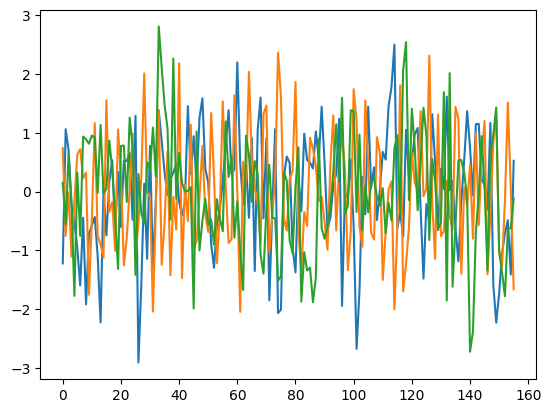

In [32]:
plt.plot(obs_list[mid,:])
plt.plot(noi_list[mid,:])
plt.plot(ffa_list[0,:])

In [33]:
obs_train = obs_list
nvoxel_train = obs_train.shape[0]
trainind_c23 = numpy.random.permutation(noi_list.shape[0])[:nvoxel_train]
tdim = obs_train.shape[1]

In [36]:
model = denoise_model_general(tdim,layers_type=["tden","tdis","tdis","conv","conv","conv"],layers_size=[128,32,16,8,4,1])
#opt = Adam(lr=0.05,beta_1=0.9, beta_2 = 0.999, decay = 0.05)
opt = Adam(lr=0.05,beta_1=0.9, beta_2 = 0.999)
model.compile(optimizer=opt,loss=denoise_loss)
epochs = 50
train_c1 = obs_train
train_c23= noi_list[trainind_c23,:,:]
y_true = numpy.ones((nvoxel_train,tdim,2))

history = model.fit([train_c1[:,[i],:] for i in range(tdim)]+
                    [train_c23[:,[i],:] for i in range(tdim)],
                    y=y_true,batch_size = 500,validation_split=0.15/0.85,epochs = epochs)

fMRIdata_q_output = model.predict([train_c1[:,[i],:] for i in range(tdim)]+
                                    [train_c1[:,[i],:] for i in range(tdim)]
                                    ,batch_size=500)
loss = history.history['loss']
valloss = history.history['val_loss']

Epoch 1/50
68/68 [==============================] - 22s 150ms/step - loss: 0.1155 - val_loss: 0.0949
Epoch 2/50
68/68 [==============================] - 5s 70ms/step - loss: 0.0966 - val_loss: 0.0891
Epoch 3/50
68/68 [==============================] - 5s 70ms/step - loss: 0.0925 - val_loss: 0.0851
Epoch 4/50
68/68 [==============================] - 5s 71ms/step - loss: 0.0870 - val_loss: 0.0812
Epoch 5/50
68/68 [==============================] - 5s 70ms/step - loss: 0.0825 - val_loss: 0.0793
Epoch 6/50
68/68 [==============================] - 5s 70ms/step - loss: 0.0796 - val_loss: 0.0764
Epoch 7/50
68/68 [==============================] - 5s 69ms/step - loss: 0.0769 - val_loss: 0.0747
Epoch 8/50
68/68 [==============================] - 5s 71ms/step - loss: 0.0754 - val_loss: 0.0737
Epoch 9/50
68/68 [==============================] - 5s 70ms/step - loss: 0.0741 - val_loss: 0.0727
Epoch 10/50
68/68 [==============================] - 5s 69ms/step - loss: 0.0732 - val_loss: 0.0719
Epoch 1

In [ ]:
plt.plot(obs_list[mid,:])
plt.plot(noi_list[mid,:])
plt.plot(fMRIdata_q_output[mid,:])

In [ ]:
print(loss[-1])
print(valloss[-1])

In [ ]:
plt.plot(loss)
plt.plot(valloss)

In [ ]:
std0 = func_values.std(axis=-1)<1e-3
brain_signals_arr = np.zeros(func_values.shape)
brain_signals_arr[gm_mask_c*~std0]=fMRIdata_q_output[:,:,0]
new_img = nib.Nifti1Image(brain_signals_arr, affine=func.affine, header=func.header)
signal_ofn = os.path.join(ofdir,f'signal_S{s}_R{r}_rep_0.nii.gz')
nib.save(new_img,signal_ofn)

In [ ]:
ffa_DeNN = brain_signals_arr[ffa_idx==1]

In [ ]:
from sklearn.decomposition import PCA
from sklearn import linear_model

conf_pcs = PCA(n_components=5).fit_transform(noi_list[:,:,0].transpose())
lin_reg = linear_model.LinearRegression()
lin_reg.fit(conf_pcs,ffa_list.transpose());
ffa_compcorr = ffa_list.transpose()-lin_reg.predict(conf_pcs)
ffa_compcorr = ffa_compcorr.transpose()

In [ ]:
outputs = {
            'recon' : ffa_DeNN, # Not used
            'signal' : ffa_DeNN,
            'noise' : ffa_DeNN, # Not used
            'ffa' : ffa_list,
            'ffa_compcorr' : ffa_compcorr,
            'face_reg' : face_reg,
            'place_reg' : face_reg} # Not 

import pickle
outputs_ofn = os.path.join(ofdir,f'outputs_S{s}_R{r}_rep_0.pickle')
with open(outputs_ofn, 'wb') as handle:
        pickle.dump(outputs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
c_ffa = correlate_columns(ffa_list.transpose(), np.array([face_reg for _ in range(ffa_list.shape[0])]).transpose())
c_compcor = correlate_columns(ffa_compcorr.transpose(), np.array([face_reg for _ in range(ffa_list.shape[0])]).transpose())
c_DeNN = correlate_columns(ffa_DeNN.transpose(), np.array([face_reg for _ in range(ffa_list.shape[0])]).transpose())

In [ ]:
xs = [0,1,2]
ys = [np.nanmean(arr) for arr in [c_ffa,c_compcor,c_DeNN]]
ys

In [ ]:
plt.bar(xs,ys)